In [1]:
import sys
sys.path.append("..")

from system_controller import SystemController, ControlNoiseInit
from utils import transform_angle_error, transform_02pi_to_negpospi, Simulator, ParametricPath, Trajectory
from neural_networks.dynamics_networks import TransferNN

import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
import os
from pathlib import Path

plt.style.use(["science", "vibrant"])

In [2]:
import tensorflow as tf

# Pendulum
Try MPPI controller with neural network dynamics model on an inverted pendulum.

### Controller Definition

In [3]:
# Get neural network model loaded
pend_model_path = Path(os.getcwd()).parent / "neural_networks" / "pendulum" / "models"
pend_availible_models = [x for x in pend_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(pend_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
pend_nn_model = tf.keras.models.load_model(pend_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/inverted_pendulum_model_16nodes_18-04-2023 04:50:54
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_rollouts__24-04-2023 23:00:02
[2]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/inverted_pendulum_model_16nodes_20-04-2023 02:54:16
[3]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_rollouts__23-04-2023 02:48:16
[4]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_tanh_32_rollouts__26-04-2023 02:34:02
[5]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_model_16nodes_rollouts
[6]  /Users/micahreich/Documents/16711-final-project/neural_networks/pendulum/models/pendulum_tanh_32_rollouts__26-04-2023 02:29:47
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [274]:
from systems.dynamical_systems import Pendulum

# Define the cartpole system parameters
pend = Pendulum(m=1, l=1, b=0.1, dt=1 / 10)

# Define the controller cost functions
DESIRED_THETA = np.pi
DESIRED_OMEGA = 0.0

def terminal_cost(x):
    theta, omega = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    omega_error = DESIRED_OMEGA - omega

    error = np.array([theta_error, omega_error])
    Q = np.diag([1e3, 1e2])

    return error.T @ Q @ error


def state_cost(x):
    theta, omega = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1

    error = np.array([theta_error])
    Q = np.diag([1e3])

    return error.T @ Q @ error

# Define the neural network and ground truth controllers
DS=pend
N_ROLLOUTS=100
HORIZON_LENGTH=10
EXPLORATION_COV=np.diag([2.0 ** 2])
EXPLORATION_LAMBDA=10
ALPHA_MU=0.1
ALPHA_SIGMA=0.985
STATE_COST=state_cost
TERMINAL_COST=terminal_cost
CONTROL_RANGE={"min": pend.u_lo, "max": pend.u_hi}
CONTROL_NOISE_INITIALIZATION=ControlNoiseInit.ZERO

nn_pend_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    state_cost=STATE_COST,
    terminal_cost=TERMINAL_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
    nn_model=pend_nn_model
)

gt_pend_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    state_cost=STATE_COST,
    terminal_cost=TERMINAL_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION
)

## Pendulum Swing Up Task
Test the MPPI controller on a swing-up task using the neural network dynamics model for rollouts.

### Simulation Definition

In [275]:
PEND_INITIAL_STATE = np.array([np.radians(0), 0])
PEND_SIMULATION_LENGTH = 11

In [280]:
nn_pend_env = Simulator(pend, controller=nn_pend_controller)
nn_pend_states, nn_pend_controls, pend_time = nn_pend_env.run(simulation_length=PEND_SIMULATION_LENGTH, initial_state=PEND_INITIAL_STATE,
                                               controlled=True, timing=True)

gt_pend_env = Simulator(pend, controller=gt_pend_controller)
gt_pend_states, gt_pend_controls, pend_time = gt_pend_env.run(simulation_length=PEND_SIMULATION_LENGTH, initial_state=PEND_INITIAL_STATE,
                                               controlled=True, timing=True)

[Simulator] [Info] pendulum simulation elapsed time: 6.49581 s
[Simulator] [Info] pendulum simulation elapsed time: 3.53311 s


### Simulation Results

/var/folders/qn/w3_cwyl12lx4j5lszc52_bv40000gn/T/ipykernel_37679/1297725286.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


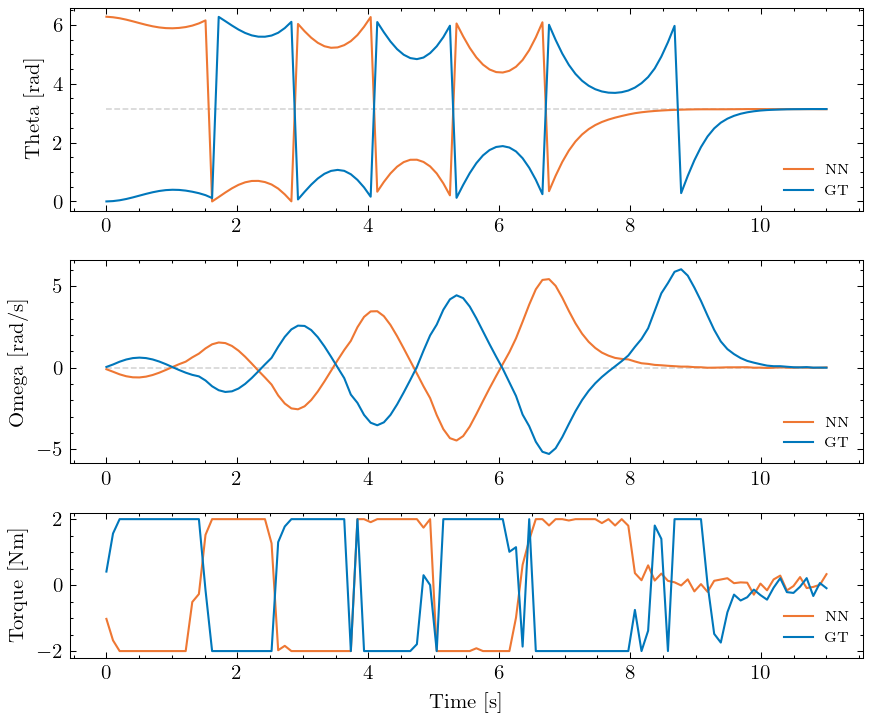

In [281]:
# Plot the results
fig, axd = plt.subplot_mosaic([['theta'],
                               ['omega'],
                               ['tau']], figsize=(6, 5), dpi=150, layout="constrained",
                               gridspec_kw={'height_ratios': [0.7, 0.7, 0.5]})

axd['theta'].plot(pend_time, [DESIRED_THETA]*len(pend_time), "--",
                  linewidth=0.75, color="lightgrey")
axd['theta'].plot(pend_time, nn_pend_states[:, 0], linewidth=1, label="NN")
axd['theta'].plot(pend_time, gt_pend_states[:, 0], linewidth=1, label="GT")
axd['theta'].set(ylabel="Theta [rad]")
axd['theta'].legend(loc="lower right", fontsize="7")


axd['omega'].plot(pend_time, [DESIRED_OMEGA]*len(pend_time), "--",
                  linewidth=0.75, color="lightgrey")
axd['omega'].plot(pend_time, nn_pend_states[:, 1], linewidth=1, label="NN")
axd['omega'].plot(pend_time, gt_pend_states[:, 1], linewidth=1, label="GT")
axd['omega'].set(ylabel="Omega [rad/s]")
axd['omega'].legend(loc="lower right", fontsize="7")


axd['tau'].plot(pend_time, nn_pend_controls[:, 0], linewidth=1, label="NN")
axd['tau'].plot(pend_time, gt_pend_controls[:, 0], linewidth=1, label="GT")
axd['tau'].set(ylabel="Torque [Nm]")
axd['tau'].legend(loc="lower right", fontsize="7")

plt.xlabel("Time [s]")
plt.tight_layout()
fig.savefig("figs/nn_vs_gt_pendulum_swingup.png")

# Cart-Pole
Try MPPI controller with a cart-pole system

### Controller Definition

In [10]:
# Get neural network model loaded
cartpole_model_path = Path(os.getcwd()).parent / "neural_networks" / "cartpole" / "models"
cartpole_availible_models = [x for x in cartpole_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(cartpole_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
cartpole_nn_model = tf.keras.models.load_model(cartpole_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/cartpole/models/cartpole_rollouts_64__26-04-2023 01:00:47
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/cartpole/models/cartpole_tanh_rollouts_64__26-04-2023 02:01:22


In [315]:
from systems.dynamical_systems import CartPole

# Define the cartpole system parameters
cartpole = CartPole(m_pole=1, m_cart=1, l=1, dt=1 / 10)

# Define the controller cost functions
DESIRED_THETA = np.pi
DESIRED_CARTVEL = 0.0
DESIRED_CARTPOS = 0.0

def terminal_cost(x):
    pos, posdot, theta, thetadot = x

    theta_error = np.cos(theta - DESIRED_THETA + np.pi) + 1
    vel_error = DESIRED_CARTVEL - posdot
    pos_error = DESIRED_CARTPOS - pos

    error = np.array([theta_error, vel_error, pos_error])
    Q = np.diag([5e4, 1e2, 5e3])

    return error.T @ Q @ error

def state_cost(x):
    return terminal_cost(x)

# Define the neural network and ground truth controllers
DS=cartpole
N_ROLLOUTS=200
HORIZON_LENGTH=10
EXPLORATION_COV=np.diag([10.0 ** 2])
EXPLORATION_LAMBDA=2e3
ALPHA_MU=0.1
ALPHA_SIGMA=0.985
TERMINAL_COST=terminal_cost
STATE_COST=state_cost
CONTROL_RANGE={"min": cartpole.u_lo, "max": cartpole.u_hi}
CONTROL_NOISE_INITIALIZATION=ControlNoiseInit.ZERO

nn_cartpole_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
    nn_model=cartpole_nn_model
)

gt_cartpole_controller = SystemController(
    ds=DS,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION
)

## Cart Pole Swing Up Task
Test the MPPI controller on a cartpole swing-up task using the neural network dynamics model for rollouts.

### Simulation Definition

In [316]:
CARTPOLE_INITIAL_STATE = np.array([0.0, 0.0, np.radians(0.0), 0.0])
CARTPOLE_SIMULATION_LENGTH = 5

nn_cartpole_env = Simulator(cartpole, controller=nn_cartpole_controller)
nn_cartpole_states, nn_cartpole_controls, cartpole_time = nn_cartpole_env.run(simulation_length=CARTPOLE_SIMULATION_LENGTH, initial_state=CARTPOLE_INITIAL_STATE,
                                                   debug=False, controlled=True, timing=True)

gt_cartpole_env = Simulator(cartpole, controller=gt_cartpole_controller)
gt_cartpole_states, gt_cartpole_controls, cartpole_time = gt_cartpole_env.run(simulation_length=CARTPOLE_SIMULATION_LENGTH, initial_state=CARTPOLE_INITIAL_STATE,
                                                   controlled=True, timing=True)

KeyboardInterrupt: 

### Simulation Results

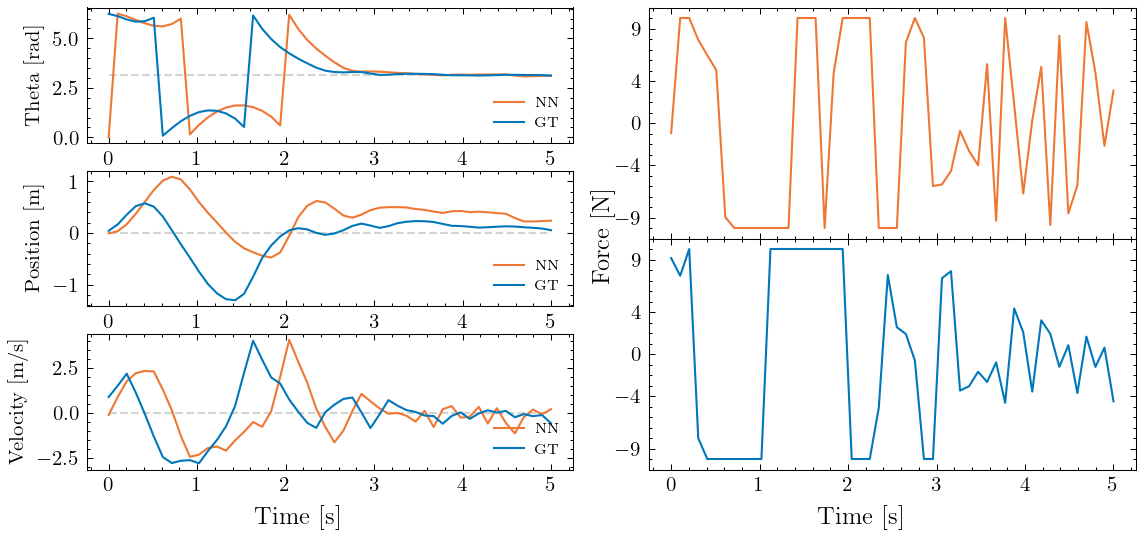

In [312]:
fig3 = plt.figure(dpi=150, figsize=(7.5, 4))
left_fig, right_fig = fig3.subfigures(1, 2)

left_fig.supxlabel("Time [s]")
right_fig.supxlabel("Time [s]")

gsR = right_fig.add_gridspec(2, 1, hspace=0.0, wspace=0.5)
right_fig.supylabel("Force [N]")


left_fig.subplots_adjust(right=0.99)


axR_F_nn = right_fig.add_subplot(gsR[0, :])
axR_F_gt = right_fig.add_subplot(gsR[1, :])

axR_F_nn.plot(cartpole_time, nn_cartpole_controls[:, 0], linewidth=1, label="NN")
axR_F_nn.set(yticks=[-9, -4, 0, 4, 9])

axR_F_gt.plot(cartpole_time, gt_cartpole_controls[:, 0], linewidth=1, label="GT", color="#0077bb")
axR_F_gt.set(yticks=[-9, -4, 0, 4, 9])

ax_theta, ax_pos, ax_vel = left_fig.subplots(3, 1)

ax_theta.plot(cartpole_time, [DESIRED_THETA]*len(cartpole_time), "--",
                  linewidth=1, color="lightgrey")
ax_theta.plot(cartpole_time, nn_cartpole_states[:, 2], linewidth=1, label="NN")
ax_theta.plot(cartpole_time, gt_cartpole_states[:, 2], linewidth=1, label="GT")
ax_theta.set(ylabel="Theta [rad]")
ax_theta.legend(loc="lower right", fontsize="7")


ax_pos.plot(cartpole_time, [DESIRED_CARTPOS]*len(cartpole_time), "--",
                linewidth=1, color="lightgrey")
ax_pos.plot(cartpole_time, nn_cartpole_states[:, 0], linewidth=1, label="NN")
ax_pos.plot(cartpole_time, gt_cartpole_states[:, 0], linewidth=1, label="GT")
ax_pos.set(ylabel="Position [m]")
ax_pos.legend(loc="lower right", fontsize="7")


ax_vel.plot(cartpole_time, [DESIRED_CARTVEL]*len(cartpole_time), "--",
                linewidth=1, color="lightgrey")
ax_vel.plot(cartpole_time, nn_cartpole_states[:, 1], linewidth=1, label="NN")
ax_vel.plot(cartpole_time, gt_cartpole_states[:, 1], linewidth=1, label="GT")
ax_vel.set(ylabel="Velocity [m/s]")
ax_vel.legend(loc="lower right", fontsize="7")

fig3.savefig("figs/gt_vs_nn_cartpole_swingup.png")

# Planar 2R Dynamic Arm
Try MPPI controller with a planar two-link robot arm modeled with its EOMs.

### Controller Definition

In [32]:
# Get neural network model loaded
arm_model_path = Path(os.getcwd()).parent / "neural_networks" / "arm" / "models"
arm_availible_models = [x for x in arm_model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(arm_availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
arm_nn_model = tf.keras.models.load_model(arm_availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/arm/models/arm_tanh_rollouts_128__01-05-2023 05:01:49
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/arm/models/arm_tanh_rollouts_128__01-05-2023 04:55:43
[2]  /Users/micahreich/Documents/16711-final-project/neural_networks/arm/models/arm_tanh_rollouts_128__01-05-2023 05:07:08
[3]  /Users/micahreich/Documents/16711-final-project/neural_networks/arm/models/arm_tanh_rollouts_128_neg4to4__01-05-2023 05:16:43


In [387]:
def line(t):
    L=1.5
    return np.array([L*(1-t) + 2 - L, 0.0])

def semicircle(t):
    R = 2
    return np.array([R*np.cos(np.pi*t)+(2-R), R*np.sin(np.pi*t)])

def circle(t):
    R, tau = 0.8, 2*np.pi
    return np.array([R*np.cos(tau*t)+(2-R), R*np.sin(tau*t)])

def infty(t):
    R, tau = 2, 2*np.pi
    return np.array([R*np.cos(tau*t), R*np.sin(tau*t)*np.cos(tau*t)])

path = ParametricPath(parametric_eqn=infty, time_length=8)

### Trajectory Tracking Example

In [388]:
from systems.dynamical_systems import Planar2RArm, FK2R, IK2R

# Define the cartpole system parameters
M1 = M2 = 1
L1 = L2 = 1
R1 = R2 = L1 / 2
I1 = I2 = 1/3 * M1 * L1**2

arm = Planar2RArm(
    m1=M1, m2=M2, l1=L1, l2=L2, r1=R1, r2=R2, I1=I1, I2=I2, dt=1/20
)

ik = IK2R(arm)

ARM_ACCEL_STDDEV = 3.0

# Define the controller cost functions
def terminal_cost(path):
    def tc(x):
        t1, dot_t1, t2, dot_t2, param, _ = x
        DESIRED_POSITION = path(param)
    
        pose = arm.fk(t1, t2)
        pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])

        error = np.array([pos_error, dot_t1, dot_t2])
        Q = np.diag([5e2, 5e2, 5e1])

        return np.dot(error, np.dot(Q, error)).astype(np.float64)
    return tc

def state_cost(path):
    def sc(x):
        t1, dot_t1, t2, dot_t2, param, _ = x
        DESIRED_POSITION = path(param)

        pose = arm.fk(t1, t2)
        pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])

        error = np.array([pos_error])
        Q = np.diag([5e3])

        return np.dot(error, np.dot(Q, error)).astype(np.float64)
    return sc

# Define the neural network and ground truth controllers
DS=arm
INVERSE_DYN_CONTROL=True
N_ROLLOUTS=150
HORIZON_LENGTH=30
EXPLORATION_COV=np.diag([ARM_ACCEL_STDDEV ** 2, ARM_ACCEL_STDDEV ** 2])
EXPLORATION_LAMBDA=4e2
ALPHA_MU=0.1
ALPHA_SIGMA=0.985
TERMINAL_COST=terminal_cost(path)
STATE_COST=state_cost(path)
CONTROL_RANGE={"min": arm.u_lo, "max": arm.u_hi}
INCLUDE_NULL_CONTROLS=False
CONTROL_NOISE_INITIALIZATION=ControlNoiseInit.ZERO

nn_arm_controller = SystemController(
    ds=DS,
    inverse_dyn_control=INVERSE_DYN_CONTROL,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    include_null_controls=INCLUDE_NULL_CONTROLS,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
    nn_model=arm_nn_model
)

gt_arm_controller = SystemController(
    ds=DS,
    inverse_dyn_control=INVERSE_DYN_CONTROL,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    include_null_controls=INCLUDE_NULL_CONTROLS,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
)

### Simulation Definition

In [389]:
ARM_T1_0, ARM_T2_0 = ik.solve(np.array([2, 0, 0])) + np.array([np.pi/2, 0])
ARM_INITIAL_STATE = np.array([ARM_T1_0, 0, ARM_T2_0, 0, 0, 1], dtype=np.float64)
ARM_SIMULATION_LENGTH = 9

nn_arm_env = Simulator(arm, controller=nn_arm_controller)
nn_arm_states, nn_arm_controls, arm_time = nn_arm_env.run(simulation_length=ARM_SIMULATION_LENGTH, initial_state=ARM_INITIAL_STATE,
                                               controlled=True, timing=True, debug=False)

gt_arm_env = Simulator(arm, controller=gt_arm_controller)
gt_arm_states, gt_arm_controls, arm_time = gt_arm_env.run(simulation_length=ARM_SIMULATION_LENGTH, initial_state=ARM_INITIAL_STATE,
                                               controlled=True, timing=True)

[Simulator] [Info] planar_2r_arm simulation elapsed time: 14.14197 s
[Simulator] [Info] planar_2r_arm simulation elapsed time: 13.75939 s


Mean Position Error: 77.4264 mm


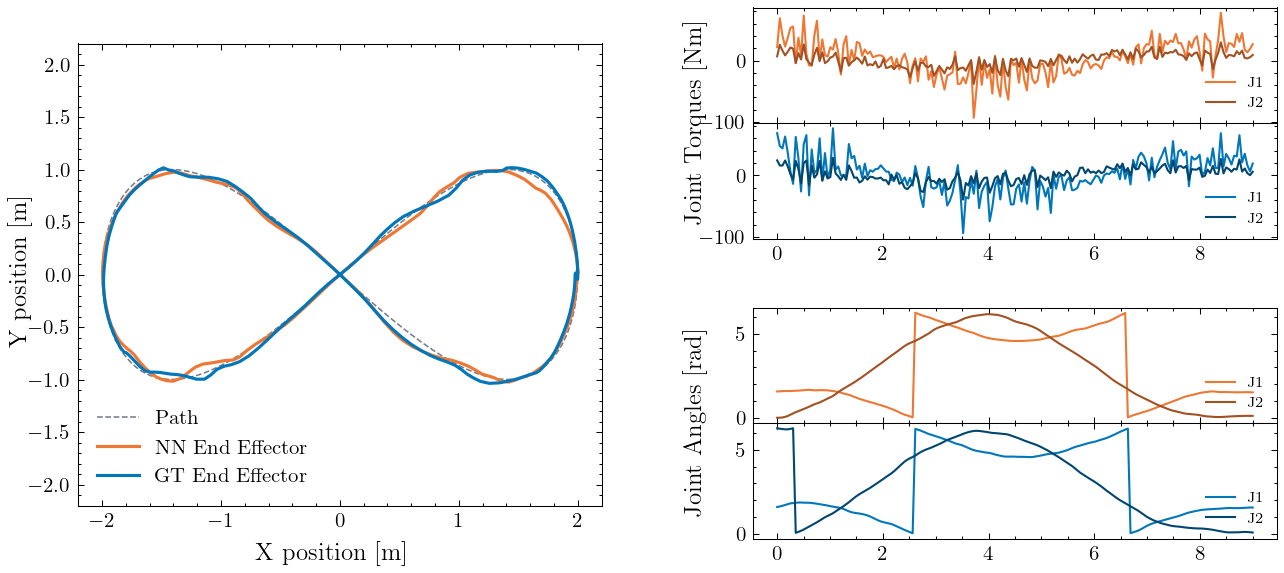

In [390]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

# Define helper functions to get some data on path tracking success
def mean_position_error(eef_positions, path_positions):
    return np.mean(
        np.linalg.norm(eef_positions - path_positions, axis=1)
    )

# Plot the results
fig3 = plt.figure(dpi=150, figsize=(9, 4))
left_fig, right_fig = fig3.subfigures(1, 2)

# right_fig.subplots_adjust(left=-0.05)


left_fig.supylabel("Y position [m]")
left_fig.supxlabel("X position [m]")

# Left subfigure
axL = left_fig.subplots(1, 1)

top_right_fig, bottom_right_fig = right_fig.subfigures(2, 1)

# Top right subfigure
gsTR = top_right_fig.add_gridspec(2, 1, hspace=0.0, wspace=0.0)
top_right_fig.supylabel("Joint Torques [Nm]")

axTR_tau_nn = top_right_fig.add_subplot(gsTR[0, :])
axTR_tau_gt = top_right_fig.add_subplot(gsTR[1, :])

# Bottom right subfigure
gsBR = bottom_right_fig.add_gridspec(2, 1, hspace=0.0, wspace=0.0)
bottom_right_fig.supylabel("Joint Angles [rad]")

axBR_ja_nn = bottom_right_fig.add_subplot(gsBR[0, :])
axBR_ja_gt = bottom_right_fig.add_subplot(gsBR[1, :])



fk_v = np.vectorize(arm.fk, signature="(),()->(3)")

nn_eef_positions = fk_v(nn_arm_states[:, 0], nn_arm_states[:, 2])
gt_eef_positions = fk_v(gt_arm_states[:, 0], gt_arm_states[:, 2])

path_positions = path.get_points(arm_time)



# Plot end effector XY positions on large canvas
axL.plot(path_positions[:, 0], path_positions[:, 1], label="Path",
            ls="--", linewidth=0.75, color="#747d8c")

axL.plot(nn_eef_positions[:, 0], nn_eef_positions[:, 1], linewidth=1.5, label="NN End Effector")
axL.plot(gt_eef_positions[:, 0], gt_eef_positions[:, 1], linewidth=1.5, label="GT End Effector")

axL.set(ylim=(-2.2, 2.2), xlim=(-2.2, 2.2))
axL.legend(loc="lower left")



# Plot joint torques
axTR_tau_nn.plot(arm_time, nn_arm_controls[:, 0], label="J1")
axTR_tau_nn.plot(arm_time, nn_arm_controls[:, 1], label="J2", color="#a15122")
axTR_tau_nn.legend(loc="lower right", fontsize="7")

axTR_tau_gt.plot(arm_time, gt_arm_controls[:, 0], label="J1", color="#0077bb")
axTR_tau_gt.plot(arm_time, gt_arm_controls[:, 1], label="J2", color="#00466e")
axTR_tau_gt.legend(loc="lower right", fontsize="7")



# Plot end effector positions
y_lims = (-2.3, 2.3)
axBR_ja_nn.plot(arm_time, nn_arm_states[:, 0], label="J1")
axBR_ja_nn.plot(arm_time, nn_arm_states[:, 2], label="J2", color="#a15122")
axBR_ja_nn.legend(loc="lower right", fontsize="7")



axBR_ja_gt.plot(arm_time, gt_arm_states[:, 0], label="J1", color="#0077bb")
axBR_ja_gt.plot(arm_time, gt_arm_states[:, 2], label="J2", color="#00466e")
axBR_ja_gt.legend(loc="lower right", fontsize="7")


# fig3.tight_layout()
fig3.savefig("figs/arm_traj_follow.png")

print("Mean Position Error: {:.4f} mm".format(1e3 * mean_position_error(nn_eef_positions[:, :2], path_positions)))

### Point Stabilization Example

In [392]:
from systems.dynamical_systems import Planar2RArm, FK2R, IK2R

# Define the cartpole system parameters
DESIRED_POSITION = np.array([-1.0, 1.0])

# Define the controller cost functions
def terminal_cost(x):
    t1, dot_t1, t2, dot_t2, param, _ = x
    
    pose = arm.fk(t1, t2)
    pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])

    error = np.array([pos_error, dot_t1, dot_t2])
    Q = np.diag([5e2, 5e2, 5e1])

    return np.dot(error, np.dot(Q, error)).astype(np.float64)

def state_cost(x):
    t1, dot_t1, t2, dot_t2, param, _ = x

    pose = arm.fk(t1, t2)
    pos_error = np.linalg.norm(DESIRED_POSITION - pose[:2])

    error = np.array([pos_error])
    Q = np.diag([5e3])

    return np.dot(error, np.dot(Q, error)).astype(np.float64)

# Define the neural network and ground truth controllers
DS=arm
INVERSE_DYN_CONTROL=True
N_ROLLOUTS=150
HORIZON_LENGTH=30
EXPLORATION_COV=np.diag([ARM_ACCEL_STDDEV ** 2, ARM_ACCEL_STDDEV ** 2])
EXPLORATION_LAMBDA=3e3
ALPHA_MU=0.1
ALPHA_SIGMA=0.98
TERMINAL_COST=terminal_cost
STATE_COST=state_cost
CONTROL_RANGE={"min": arm.u_lo, "max": arm.u_hi}
INCLUDE_NULL_CONTROLS=False
CONTROL_NOISE_INITIALIZATION=ControlNoiseInit.ZERO

nn_arm_ps_controller = SystemController(
    ds=DS,
    inverse_dyn_control=INVERSE_DYN_CONTROL,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    include_null_controls=INCLUDE_NULL_CONTROLS,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
    nn_model=arm_nn_model
)

gt_arm_ps_controller = SystemController(
    ds=DS,
    inverse_dyn_control=INVERSE_DYN_CONTROL,
    n_rollouts=N_ROLLOUTS,
    horizon_length=HORIZON_LENGTH,
    exploration_cov=EXPLORATION_COV,
    exploration_lambda=EXPLORATION_LAMBDA,
    alpha_mu=ALPHA_MU,
    alpha_sigma=ALPHA_SIGMA,
    terminal_cost=TERMINAL_COST,
    state_cost=STATE_COST,
    control_range=CONTROL_RANGE,
    include_null_controls=INCLUDE_NULL_CONTROLS,
    control_noise_initialization=CONTROL_NOISE_INITIALIZATION,
)

In [393]:
ARM_PS_SIMULATION_LENGTH = 5

nn_arm_env = Simulator(arm, controller=nn_arm_ps_controller)
nn_arm_states, nn_arm_controls, arm_time = nn_arm_env.run(simulation_length=ARM_PS_SIMULATION_LENGTH, initial_state=ARM_INITIAL_STATE,
                                               controlled=True, timing=True, debug=False)

gt_arm_env = Simulator(arm, controller=gt_arm_ps_controller)
gt_arm_states, gt_arm_controls, arm_time = gt_arm_env.run(simulation_length=ARM_PS_SIMULATION_LENGTH, initial_state=ARM_INITIAL_STATE,
                                               controlled=True, timing=True)

[Simulator] [Info] planar_2r_arm simulation elapsed time: 6.87856 s
[Simulator] [Info] planar_2r_arm simulation elapsed time: 6.87776 s


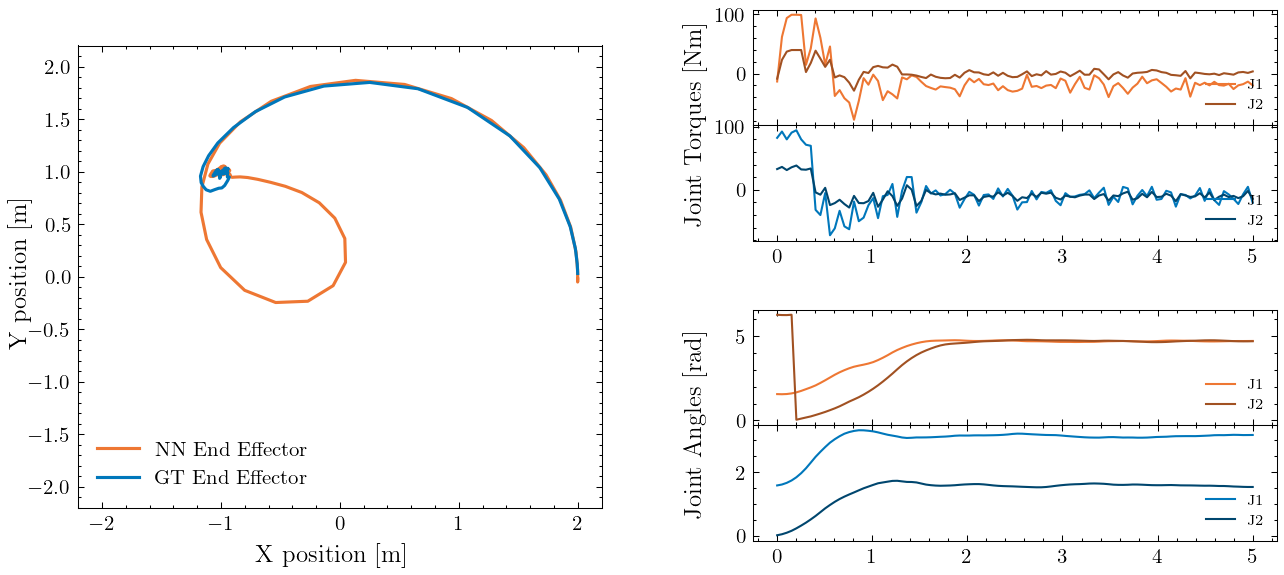

In [394]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

# Define helper functions to get some data on path tracking success
def mean_position_error(_eef_positions, _path_positions):
    return np.mean(
        np.linalg.norm(_eef_positions - _path_positions, axis=1)
    )

# Plot the results
fig3 = plt.figure(dpi=150, figsize=(9, 4))
left_fig, right_fig = fig3.subfigures(1, 2)

# right_fig.subplots_adjust(left=-0.05)


left_fig.supylabel("Y position [m]")
left_fig.supxlabel("X position [m]")

# Left subfigure
axL = left_fig.subplots(1, 1)

top_right_fig, bottom_right_fig = right_fig.subfigures(2, 1)

# Top right subfigure
gsTR = top_right_fig.add_gridspec(2, 1, hspace=0.0, wspace=0.0)
top_right_fig.supylabel("Joint Torques [Nm]")

axTR_tau_nn = top_right_fig.add_subplot(gsTR[0, :])
axTR_tau_gt = top_right_fig.add_subplot(gsTR[1, :])

# Bottom right subfigure
gsBR = bottom_right_fig.add_gridspec(2, 1, hspace=0.0, wspace=0.0)
bottom_right_fig.supylabel("Joint Angles [rad]")

axBR_ja_nn = bottom_right_fig.add_subplot(gsBR[0, :])
axBR_ja_gt = bottom_right_fig.add_subplot(gsBR[1, :])


nn_eef_positions = fk_v(nn_arm_states[:, 0], nn_arm_states[:, 2])
gt_eef_positions = fk_v(gt_arm_states[:, 0], gt_arm_states[:, 2])


# Plot end effector XY positions on large canvas
axL.plot(nn_eef_positions[:, 0], nn_eef_positions[:, 1], linewidth=1.5, label="NN End Effector")
axL.plot(gt_eef_positions[:, 0], gt_eef_positions[:, 1], linewidth=1.5, label="GT End Effector")

axL.set(ylim=(-2.2, 2.2), xlim=(-2.2, 2.2))
axL.legend(loc="lower left")



# Plot joint torques
axTR_tau_nn.plot(arm_time, nn_arm_controls[:, 0], label="J1")
axTR_tau_nn.plot(arm_time, nn_arm_controls[:, 1], label="J2", color="#a15122")
axTR_tau_nn.legend(loc="lower right", fontsize="7")

axTR_tau_gt.plot(arm_time, gt_arm_controls[:, 0], label="J1", color="#0077bb")
axTR_tau_gt.plot(arm_time, gt_arm_controls[:, 1], label="J2", color="#00466e")
axTR_tau_gt.legend(loc="lower right", fontsize="7")



# Plot end effector positions
y_lims = (-2.3, 2.3)
axBR_ja_nn.plot(arm_time, nn_arm_states[:, 0], label="J1")
axBR_ja_nn.plot(arm_time, nn_arm_states[:, 2], label="J2", color="#a15122")
axBR_ja_nn.legend(loc="lower right", fontsize="7")



axBR_ja_gt.plot(arm_time, gt_arm_states[:, 0], label="J1", color="#0077bb")
axBR_ja_gt.plot(arm_time, gt_arm_states[:, 2], label="J2", color="#00466e")
axBR_ja_gt.legend(loc="lower right", fontsize="7")


# fig3.tight_layout()
fig3.savefig("figs/arm_traj_follow.png")

# print("Mean Position Error: {:.4f} mm".format(1e3 * mean_position_error(nn_eef_positions[:, :2], path_positions)))

# NN vs. GT Cost Comparison
Compare mean trajectory costs between neural network controllers and ground truth dynamics controllers.

In [397]:
from tqdm import tqdm
from datetime import datetime


class NNGTComparison:
    def __init__(self, ds, gt_controller, nn_controller):
        self.ds = ds
        self.gt_controller = gt_controller
        self.nn_controller = nn_controller
    
    def compare_trajectory_costs(self, n_samples, initial_state, simulation_length):
        state_cost = self.gt_controller.controller._state_cost
        control_cost = self.gt_controller.controller._control_cost
        terminal_cost = self.gt_controller._terminal_cost

        nn_cumcosts = np.zeros(n_samples)
        gt_cumcosts = np.zeros(n_samples)

        nn_env = Simulator(self.ds, controller=self.nn_controller)
        gt_env = Simulator(self.ds, controller=self.gt_controller)

        for i in tqdm(range(n_samples)):
            state_0 = initial_state()
            nn_states, nn_controls, _ = nn_env.run(simulation_length=simulation_length, initial_state=state_0,
                                                   controlled=True)
            nn_cumcosts[i] = np.sum(state_cost(nn_states) + control_cost(nn_controls) + terminal_cost(nn_states[-1]))

            gt_states, gt_controls, _ = gt_env.run(simulation_length=simulation_length, initial_state=state_0,
                                                   controlled=True)
            gt_cumcosts[i] = np.sum(state_cost(gt_states) + control_cost(gt_controls) + terminal_cost(gt_states[-1]))
        
        dt_string = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
        fname = "comparison_data/{}_comparison_{}".format(str(self.ds), dt_string)

        mean_nn_cost, std_nn_cost = np.mean(nn_cumcosts), np.std(nn_cumcosts)
        mean_gt_cost, std_gt_cost = np.mean(gt_cumcosts), np.std(gt_cumcosts)

        print("[Comparison] Comparison for system ({}) \n"
              "             GT cost mean: {:.4f}, GT cost variance: {:.4f} \n"
              "             NN cost mean: {:.4f}, NN cost variance: {:.4f} \n"
              "             E[C_NN] / E[C_GT] = {:.4f}".format(
                str(self.ds),
                mean_gt_cost, std_gt_cost,
                mean_nn_cost, std_nn_cost,
                mean_nn_cost / mean_gt_cost
            ))

        np.savez(fname, nn_cumcosts=nn_cumcosts, gt_cumcosts=gt_cumcosts)

## Pendulum Comparison

In [396]:
def generate_initial_pend_state():
    return PEND_INITIAL_STATE

pend_cmp = NNGTComparison(pend, gt_pend_controller, nn_pend_controller)
pend_cmp.compare_trajectory_costs(
    n_samples=20,
    initial_state=generate_initial_pend_state, simulation_length=PEND_SIMULATION_LENGTH
)

100%|██████████| 20/20 [03:15<00:00,  9.77s/it]

[Comparison] Comparison for system (pendulum) 
             GT cost mean: 408055.0263, GT cost variance: 71461.6600 
             NN cost mean: 418769.4488, NN cost variance: 55376.3749 
             E[C_NN] / E[C_GT] = 1.0263


## Cart-Pole Comparison

In [317]:
def generate_initial_cartpole_state():
    return CARTPOLE_INITIAL_STATE

cartpole_cmp = NNGTComparison(cartpole, gt_cartpole_controller, nn_cartpole_controller)
cartpole_cmp.compare_trajectory_costs(
    n_samples=20,
    initial_state=generate_initial_cartpole_state, simulation_length=CARTPOLE_SIMULATION_LENGTH
)

100%|██████████| 20/20 [02:35<00:00,  7.78s/it]

[Comparison] Comparison for system (cart_pole) 
             GT cost mean: 3826200.3924, GT cost variance: 470324.4583 
             NN cost mean: 3925445.7331, NN cost variance: 637192.1127 
             E[C_NN] / E[C_GT] = 1.0259


## 2R Arm Comparison

In [352]:
def generate_initial_arm_tt_state():
    return ARM_INITIAL_STATE

arm_cmp = NNGTComparison(arm, gt_arm_controller, nn_arm_controller)
arm_cmp.compare_trajectory_costs(
    n_samples=20,
    initial_state=generate_initial_arm_tt_state, simulation_length=ARM_SIMULATION_LENGTH
)

100%|██████████| 20/20 [09:15<00:00, 27.78s/it]

[Comparison] Comparison for system (planar_2r_arm) 
             GT cost mean: 253434.9978, GT cost variance: 507872.6234 
             NN cost mean: 253011.4424, NN cost variance: 372722.6799 
             E[C_NN] / E[C_GT] = 0.9983


In [395]:
def generate_initial_arm_ps_state():
    R = np.random.uniform(0, 2.0)
    theta = np.random.uniform(0, 2*np.pi)
    point = np.array([R * np.cos(theta), R * np.sin(theta)])

    ARM_T1_0, ARM_T2_0 = ik.solve(point) + np.array([np.pi/2, 0])
    ARM_INITIAL_STATE = np.array([ARM_T1_0, 0, ARM_T2_0, 0, 0, 1], dtype=np.float64)

    return ARM_INITIAL_STATE

arm_cmp = NNGTComparison(arm, gt_arm_ps_controller, nn_arm_ps_controller)
arm_cmp.compare_trajectory_costs(
    n_samples=20,
    initial_state=generate_initial_arm_ps_state, simulation_length=ARM_PS_SIMULATION_LENGTH
)

100%|██████████| 20/20 [04:34<00:00, 13.72s/it]

[Comparison] Comparison for system (planar_2r_arm) 
             GT cost mean: 217461.7521, GT cost variance: 182822.0433 
             NN cost mean: 224574.1585, NN cost variance: 199525.2721 
             E[C_NN] / E[C_GT] = 1.0327


In [15]:
with np.load("comparison_data/pendulum_comparison_03-05-2023 17:42:42.npz") as cd:
    nn_cumcosts = cd['nn_cumcosts']
    gt_cumcosts = cd['gt_cumcosts']

mean_nn_cost, std_nn_cost = np.mean(nn_cumcosts), np.std(nn_cumcosts)
mean_gt_cost, std_gt_cost = np.mean(gt_cumcosts), np.std(gt_cumcosts)

print("[Comparison] Comparison for system ({}) \n"
        "             GT cost mean: {:.4f}, GT cost stddev: {:.4f} \n"
        "             NN cost mean: {:.4f}, NN cost stddev: {:.4f} \n"
        "             E[C_NN] / E[C_GT] = {:.4f}".format(
        "blah",
        mean_gt_cost, std_gt_cost,
        mean_nn_cost, std_nn_cost,
        mean_nn_cost / mean_gt_cost
    ))

[Comparison] Comparison for system (blah) 
             GT cost mean: 462092.9599, GT cost stddev: 56810.8087 
             NN cost mean: 461767.8464, NN cost stddev: 56941.4656 
             E[C_NN] / E[C_GT] = 0.9993


In [ ]:

class NNRolloutComparison:
    def __init__(self, ds, gt_controller, nn_controllers):
        self.ds = ds
        self.gt_controller = gt_controller
        self.nn_controllers = nn_controllers
        self.batched_simulator = np.vectorize(self.ds.integrator.step, signature="(nx),(nu)->(nx)")
    
    def _uniform_2d_bycol(self, nr, nc, lo, hi):
        x = np.empty(shape=(nr, nc))

        for i in range(nc):
            x[:, i] = np.random.uniform(low=lo[i], high=hi[i], size=nr)
        return x

    def sample_actions(self, n_samples, u_lo, u_hi):
        return self._uniform_2d_bycol(nr=n_samples, nc=self.system.nu, lo=u_lo, hi=u_hi)

    def sample_initial_states(self, n_samples, x_lo, x_hi):
        return self._uniform_2d_bycol(nr=n_samples, nc=self.system.nx, lo=x_lo, hi=x_hi)
    
    def compute_state_RMSE(self, nn_states, gt_states):
        n_steps = nn_states.shape[2]
        RMSEs = np.empty(shape=(n_steps, self.ds.nx))

        for t in tqdm(range(n_steps)):
            nn_states_t = nn_states[:, :, t]
            gt_states_t = gt_states[:, :, t]

            for i in range(self.ds.nx):
                nn_t_i, gt_t_i = nn_states_t[:, i], gt_states_t[:, i]
                state_MSE = np.square(np.subtract(gt_t_i, nn_t_i)).mean()
                RMSE_t_i = np.sqrt(state_MSE)
                RMSEs[t, i] = RMSE_t_i
        return RMSEs

    def compute_rollout_deviations(self, n_samples, horizon_length=1):
        n_steps = int((1 / self.ds.dt) * horizon_length)
        n_networks = len(self.nn_controllers)

        gt_current_state = self.sample_initial_states(n_samples, self.ds.x_lo, self.ds.x_hi)
        nn_current_states = [gt_current_state for _ in range(n_networks)]
        
        cum_nn_states = [np.empty(shape=(n_samples, self.ds.nx, n_steps)) for _ in range(n_networks)]
        cum_gt_state = np.empty_like(cum_nn_states[0])

        for t in tqdm(range(n_steps)):
            action = self.sample_actions(n_samples, self.ds.u_lo, self.ds.u_hi)

            for network_idx in range(n_networks):
                nn_controller = self.nn_controllers[network_idx]
                nn_current_state = nn_current_states[network_idx]

                nn_input = np.hstack((nn_current_state, action)).reshape(n_samples, -1)
                nn_current_state = nn_controller.evolve_state(nn_input)
                nn_current_state = self.ds.ensure_states(nn_current_states)

                nn_current_states[network_idx] = nn_current_state
                cum_nn_states[network_idx][:, :, t] = nn_current_state

            gt_current_state = self.batched_simulator(gt_current_state, action)
            gt_current_state = self.ds.ensure_states(gt_current_state)
            
            cum_gt_state[:, :, t] = gt_current_state
        
        network_RMSEs = [self.compute_state_RMSE(cum_nn_states[i], cum_gt_state) for i in range(n_networks)]
        self.plot_state_errors(network_RMSEs, idxs=[0, 1], horizon_length=horizon_length)

    def plot_state_errors(self, network_RMSEs, idxs, horizon_length):
        fig, axs = plt.subplot(len(idxs), 1, figsize=(6, 6))
        n_networks = len(self.nn_controllers)

        for network_idx in range(n_networks):
            network_RMSE = network_RMSEs[network_idx]

            for i in range(len(idxs)):
                RMSEs_i = network_RMSE[:, idxs[i]]
                times = np.linspace(0, horizon_length, len(RMSEs_i))

                axs[i].plot(times, RMSEs_i)
        plt.show()
